In [1]:
import numpy as np
import pandas as pd
import shutil, time, os, requests, random, copy
import PIL
from PIL import Image
import matplotlib.pyplot as plt 
from tqdm import tqdm

import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms, models
from mpl_toolkits.mplot3d import Axes3D

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.manifold import TSNE

import preprocessing.VideoFrameDataset as VFD
import model.Encoder as E
import model.Loss as L

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
model = E.ResNet50Encoder()  
model = model.to(device)
state_dict = torch.load('/home/aarya/Desktop/TCLR_Frame_Based_Anomaly/kaggle_sessions/saved_models/1_28_25_0.0001_7_0.1_ResNet-50.pth')
model.load_state_dict(state_dict)

/home/aarya/miniconda3/envs/pytorch/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/aarya/miniconda3/envs/pytorch/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

In [3]:
dataset = VFD.VideoFrameDataset('/home/aarya/Desktop/TCLR_Frame_Based_Anomaly/data/camera_1_videos', 5)
dataloader = DataLoader(dataset, 1, shuffle=False)

In [4]:
datapoints = np.empty((0, 64))
with torch.no_grad():
    for batch in dataloader:
        video = batch[0]
        for frame in video:
            frame = frame.unsqueeze(dim = 0)
            frame = frame.to(device)
            output = model(frame)
            datapoints = np.vstack([datapoints, output.detach().cpu().numpy()])

In [5]:
datapoints.shape

(5600, 64)

In [6]:
tsne_2D = TSNE(n_components=2, perplexity=30)
tsne_results_2D = tsne_2D.fit_transform(datapoints)

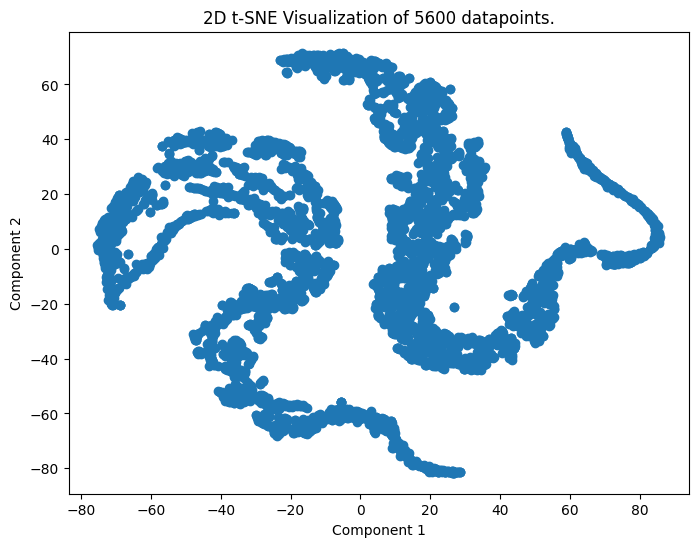

In [7]:
plt.figure(figsize=(8, 6))
plt.scatter(tsne_results_2D[:, 0], tsne_results_2D[:, 1])
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title("2D t-SNE Visualization of 5600 datapoints.")
plt.show()

In [8]:
data = datapoints
data = transforms.ToTensor()(data)
data = data.squeeze(dim = 0).to(device)
data.shape

torch.Size([5600, 64])

In [9]:
import model.Loss as L
similarity_matrix = L.pairwise_cosine_similarity(data, data)
similarity_matrix = similarity_matrix.detach().cpu().numpy()
similarity_matrix = 1 + 4.4e-15 - similarity_matrix 
similarity_matrix.min()

3.9968028886505635e-15

In [10]:
similarity_matrix.shape

(5600, 5600)

In [11]:
tsne_2D = TSNE(metric = "precomputed", init="random")
tsne_results_2D = tsne_2D.fit_transform(similarity_matrix)

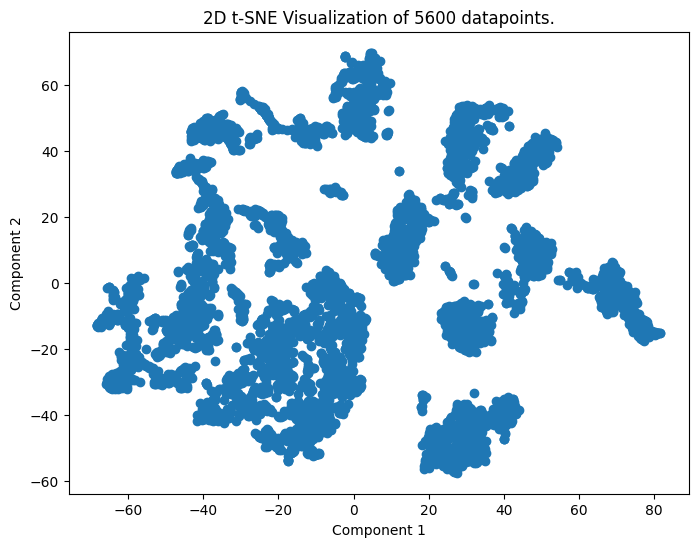

In [12]:
plt.figure(figsize=(8, 6))
plt.scatter(tsne_results_2D[:, 0], tsne_results_2D[:, 1])
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title("2D t-SNE Visualization of 5600 datapoints.")
plt.show()

In [13]:
tsne_3D = TSNE(n_components=3, perplexity=30)
tsne_results_3D = tsne_3D.fit_transform(datapoints)

In [14]:
import plotly.graph_objects as go
trace = go.Scatter3d(
    x=tsne_results_3D[:, 0],
    y=tsne_results_3D[:, 1],
    z=tsne_results_3D[:, 2],
    mode='markers',
    marker=dict(
        size=5,  # Adjust marker size as needed
        opacity=0.8,  # Adjust marker opacity as needed
    )
)

# Create the layout for the plot
layout = go.Layout(
    title="3D t-SNE Visualization",
    width=1200,  # Set width in pixels
    height=800,
    scene=dict(
        xaxis_title='Component 1',
        yaxis_title='Component 2',
        zaxis_title='Component 3'
    )
)

# Combine the trace and layout into a figure
fig = go.Figure(data=[trace], layout=layout)

# Display the interactive plot
fig.show()

In [15]:
tsne_3D = TSNE(n_components=3, perplexity=30, metric='cosine')
tsne_results_3D = tsne_3D.fit_transform(datapoints)

In [16]:
import plotly.graph_objects as go
trace = go.Scatter3d(
    x=tsne_results_3D[:, 0],
    y=tsne_results_3D[:, 1],
    z=tsne_results_3D[:, 2],
    mode='markers',
    marker=dict(
        size=5,  # Adjust marker size as needed
        opacity=0.8,  # Adjust marker opacity as needed
    )
)

# Create the layout for the plot
layout = go.Layout(
    title="3D t-SNE Visualization",
    width=1200,  # Set width in pixels
    height=800,
    scene=dict(
        xaxis_title='Component 1',
        yaxis_title='Component 2',
        zaxis_title='Component 3'
    )
)

# Combine the trace and layout into a figure
fig = go.Figure(data=[trace], layout=layout)

# Display the interactive plot
fig.show()

In [17]:
transform = transforms.ToTensor()
anomalous = cv2.imread('anomalous_frame.jpg')
anomalous = Image.fromarray(anomalous)
anomalous = transform(anomalous).to(device)
anomalous = anomalous.unsqueeze(dim=0)
anomalous.shape

torch.Size([1, 3, 256, 256])

In [18]:
with torch.no_grad():
    anomalous = model(anomalous)

In [19]:
datapoints = np.vstack([datapoints, anomalous.detach().cpu().numpy()])
datapoints = np.vstack([datapoints, anomalous.detach().cpu().numpy()])

In [20]:
tsne_2D = TSNE(n_components=2, perplexity=30, metric='cosine')
tsne_results_2D = tsne_2D.fit_transform(datapoints)

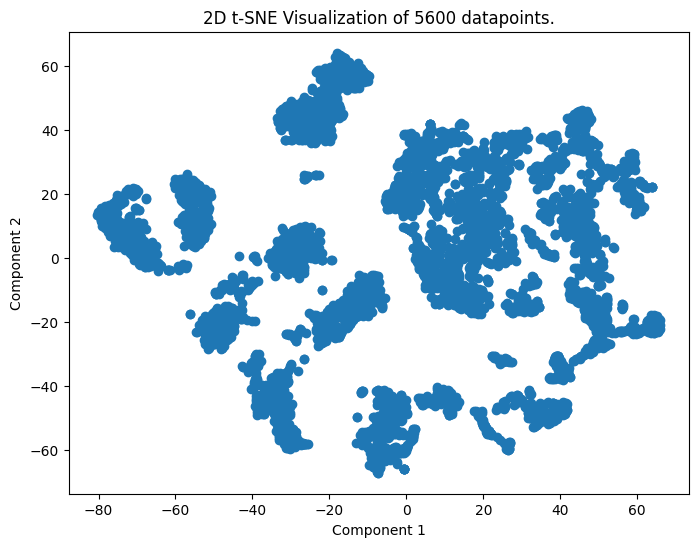

In [21]:
plt.figure(figsize=(8, 6))
plt.scatter(tsne_results_2D[:, 0], tsne_results_2D[:, 1])
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title("2D t-SNE Visualization of 5600 datapoints.")
plt.show()

In [22]:
from model.Loss import pairwise_cosine_similarity
print(datapoints.shape)
tr = transforms.ToTensor()
data = tr(datapoints).squeeze(dim = 0)
print(data.shape)
similarity_matrix = pairwise_cosine_similarity(data, data).numpy()

(5602, 64)
torch.Size([5602, 64])


In [23]:
print(similarity_matrix.min())
print(similarity_matrix.max())
print(similarity_matrix.mean())

0.9940112918334769
1.0000000000000004
0.9996989966828819


In [24]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)
scaled_data = tr(scaled_data)
scaled_data = scaled_data.squeeze(dim = 0)


In [25]:
similarity_matrix = pairwise_cosine_similarity(scaled_data, scaled_data).numpy() + 1

In [26]:
print(similarity_matrix.min())
print(similarity_matrix.max())
print(similarity_matrix.mean())

0.00013542906847952008
2.000000000000001
1.0020900135844173


In [27]:
from sklearn.cluster import DBSCAN
i = 0.1
while(i!=1):
    eps = i # Maximum allowed distance for points to be considered neighbors
    min_samples = 2800 # Minimum number of neighbors to form a cluster
    dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='precomputed')

    # Fit the model on the similarity matrix
    dbscan.fit(similarity_matrix)

    # Get labels for each data point
    labels = dbscan.labels_

    # Identify anomalies (points labeled -1, noise)
    anomalies = data[labels == -1]

    # Print the number of anomalies found
    print(f"Number of anomalies found: {len(anomalies)} at {i}")
    if(len(anomalies) == 0):
        break
    i += 0.01

Number of anomalies found: 56 at 0.1
Number of anomalies found: 53 at 0.11
Number of anomalies found: 52 at 0.12
Number of anomalies found: 50 at 0.13
Number of anomalies found: 43 at 0.14
Number of anomalies found: 40 at 0.15000000000000002
Number of anomalies found: 37 at 0.16000000000000003
Number of anomalies found: 34 at 0.17000000000000004
Number of anomalies found: 34 at 0.18000000000000005
Number of anomalies found: 33 at 0.19000000000000006
Number of anomalies found: 32 at 0.20000000000000007
Number of anomalies found: 30 at 0.21000000000000008
Number of anomalies found: 29 at 0.22000000000000008
Number of anomalies found: 28 at 0.2300000000000001
Number of anomalies found: 26 at 0.2400000000000001
Number of anomalies found: 24 at 0.2500000000000001
Number of anomalies found: 24 at 0.2600000000000001
Number of anomalies found: 23 at 0.27000000000000013
Number of anomalies found: 22 at 0.28000000000000014
Number of anomalies found: 21 at 0.29000000000000015
Number of anomalies 

In [29]:
datapoints = np.empty((0, 64))
with torch.no_grad():
    for batch in dataloader:
        video = batch[0]
        for frame in video:
            frame = frame.unsqueeze(dim = 0)
            frame = frame.to(device)
            output = model(frame)
            datapoints = np.vstack([datapoints, output.detach().cpu().numpy()])

In [30]:
datapoints.shape

(5600, 64)

/home/aarya/miniconda3/envs/pytorch/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



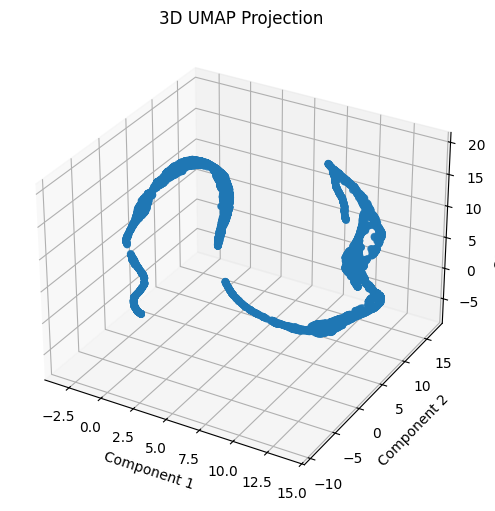

In [32]:
import umap

# Assuming your data is in a numpy array called 'your_data_array'
# Reduce dimensionality to 3 for UMAP
reducer = umap.UMAP(n_components=3)
embedded = reducer.fit_transform(datapoints)

# Extract components for separate plotting
component_1 = embedded[:, 0]
component_2 = embedded[:, 1]
component_3 = embedded[:, 2]

# 3D scatter plot (consider performance for large datasets)
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(component_1, component_2, component_3, alpha=0.8)

# Customize plot (optional)
ax.set_xlabel("Component 1")
ax.set_ylabel("Component 2")
ax.set_zlabel("Component 3")
ax.set_title("3D UMAP Projection")
plt.show()

In [44]:
from plotly.graph_objs import Scatter3d

component_1 = embedded[:, 0]
component_2 = embedded[:, 1]
component_3 = embedded[:, 2]

trace = Scatter3d(
    x=component_1,
    y=component_2,
    z=component_3,
    mode='markers',
    marker=dict(
        size=5,
        opacity=0.8,
    )
)

# Configure layout for interactivity
layout = dict(
    title='3D UMAP Projection (Interactive)',
    margin=dict(t=20, l=10, r=10, b=10),
    scene=dict(
        xaxis=dict(title='Component 1'),
        yaxis=dict(title='Component 2'),
        zaxis=dict(title='Component 3'),
        camera=dict(
            up=dict(x=0, y=0, z=1),
            eye=dict(x=1.25, y=-1.25, z=1.0)
        )
    )
)

# Create plotly figure and display
fig = dict(data=[trace], layout=layout)
import plotly.offline as pyo
pyo.plot(fig)

'temp-plot.html'

Opening in existing browser session.
